Copyright (c) 2024 Massachusetts Institute of Technology

SPDX-License-Identifier: MIT

# Propagate Satellites without Maneuvers

In this example we will use the tools in `madlib` to create satellites, propagate their orbits, and plot their positions over time.

## Defining Satellites
To start, let's define a few satellites using the different instantiation methods available in `madlib`. We'll create the following:

1. A low-Earth orbit (LEO) satellite defined by its initial position and velocity
2. A satellite in a Molniya orbit defined by its Keplerian elements
3. A GEO satellite defined by the surface longitude directly beneath it

We'll need to first import `madlib` and `numpy` libraries.

In [1]:
import madlib
import numpy as np

### Position/Velocity method

Let's start with the LEO object. Looking at a [tracking map](https://spotthestation.nasa.gov/tracking_map.cfm) of the ISS, I can see that its altitude is roughly **430 km**, and its speed is approximately **27,500 km/h**. We'll use those same values for our satellite.

The primary coordinate system used in `madlib` is *TETED* (True Equinox and True Equator of Date, see [here](https://docs.astropy.org/en/stable/api/astropy.coordinates.TETE.html) and [here](https://en.wikipedia.org/wiki/Equatorial_coordinate_system#Primary_direction)), and it uses the units of km and km/s. We'll place our object on the x-axis at an altitude of 430 km, and we'll give it an initial velocity vector in the y-z plane.

In [2]:
leo_alt_km = 430.0
leo_speed_kms = 27500.0 / 3600  # Converting from km/h to km/s
earth_radius_km = 6378.0

leo_pos_teted = np.array([leo_alt_km + earth_radius_km, 0, 0])
leo_vel_teted = leo_speed_kms * np.array([0, 2**-0.5, 2**-0.5])

Lastly, we need to define the satellite's epoch. All epoch and observation times in `madlib` are handled in modified Julian dates (MJD) format.

The MJD at the time of writing is roughly **60197.5**, so let's go with that.

In [3]:
leo_mjd = 60197.5

Now we can define a `Satellite` object representing our LEO satellite. Printing the object will display a summary of its state at epoch.

Note that "acc" refers to anomalous acceleration (acceleration due to non-natural forces, such as maneuver thrusts).

In [4]:
leo_satellite = madlib.Satellite(epoch=leo_mjd, pos=leo_pos_teted, vel=leo_vel_teted)
print(leo_satellite)

Satellite:
  epoch = 2023-09-10T12:00:00.000
  x = [6808.0, 0.0, 0.0]
  v = [0.0, 5.401510134063906, 5.401510134063906]
  acc = [0.0, 0.0, 0.0]


### Keplerian element method
If we instead would like to define a satellite using the Keplerian elements of its orbit, we can do so easily with `madlib`. The orbit must be defined with the following quantities (with angles expressed as radians):
- Orbit epoch in MJD format
- Inclination
- Right ascension of the ascending node
- Argument of pericenter
- Eccentricity
- Semi-major axis (in km)
- Mean anomaly

For our example, let's create an object in a [Molniya orbit](https://en.wikipedia.org/wiki/Molniya_orbit).

In [5]:
# Define the elements for a Molniya orbit and convert them to the proper units
deg2rad = np.pi / 180
mol_arg_peri = 270 * deg2rad
mol_inc = 63.4 * deg2rad
mol_ecc = 0.74
mol_sma = 26600  # km

# The RAAN and MA are arbitrary
mol_raan = 0
mol_mean_anom = 0

# We'll use the same starting epoch as our previous example
mol_mjd = 60197.5

Next, we simply need to call the `madlib.Satellite.from_keplerian` class method.

In [6]:
mol_satellite = madlib.Satellite.from_keplerian(
    epoch=mol_mjd,
    inclination_rad=mol_inc,
    raan_rad=mol_raan,
    argp_rad=mol_arg_peri,
    ecc=mol_ecc,
    semi_major_axis_km=mol_sma,
    mean_anomaly_rad=mol_mean_anom,
)
print(mol_satellite)

Satellite:
  epoch = 2023-09-10T12:00:00.000
  x = [-1.2704485894354642e-12, -3096.7018514929314, -6183.970701981069]
  v = [10.014194442460434, -8.236876219903357e-16, -1.6448661725432242e-15]
  acc = [0.0, 0.0, 0.0]


The created object is of the exact same `Satellite` class as our positon/velocity example. We can see here that `madlib` has automatically calculated the position and velocity of the new object at the orbital epoch.

### Longitude method (for GEO satellites)
If we want a GEO object, `madlib` provides a simple way to define it. We just need the starting epoch in MJD and the longitude (in degrees) of the point on Earth directly beneath it. Let's generate a GEO satellite at a random longitude using the same epoch as the LEO object.

In [7]:
theta_deg = 360.0 * np.random.rand()
geo_mjd = 60197.5
geo_satellite = madlib.Satellite.from_GEO_longitude(lon=theta_deg, epoch=geo_mjd)
print(geo_satellite)

Satellite:
  epoch = 2023-09-10T12:00:00.000
  x = [38422.22030609974, -17365.20710848653, -0.07983187096972996]
  v = [1.2662909288325055, 2.8017926152446964, -1.1108546245929562e-09]
  acc = [0.0, 0.0, 0.0]


## Propagating Satellites
Now that we've defined our satellites, we can propagate their orbits and observe how their states change over time.

We start by defining the observation times, again in MJD format. These are the timestamps at which we'll measure the satellites' states (not the integration timesteps!). We'll make an observation every 10 minutes for a full day, starting two days after the satellites' epoch.

In [8]:
dt = 10.0 / 60 / 24  # 10 minutes converted into days
obs_start_mjd = leo_mjd + 2.0
obs_end_mjd = obs_start_mjd + 1.0 + dt  # Add an extra step to handle open interval
obs_times_mjd = np.arange(obs_start_mjd, obs_end_mjd, dt)

Now all we have to do is call each `Satellite` object's `self.propagate` function. This takes the observation timestamps as an input and outputs a tuple with the position and velocity vectors (in TETED coordinates).

In [9]:
leo_x, leo_v = leo_satellite.propagate(obs_times_mjd)
mol_x, mol_v = mol_satellite.propagate(obs_times_mjd)
geo_x, geo_v = geo_satellite.propagate(obs_times_mjd)

Finally, let's make some plots of these orbits.

In [10]:
from matplotlib import pyplot as plt
%matplotlib inline

In [11]:
def plot_satellite_pos(times, pos_vector, satellite_name):
    x = pos_vector[:, 0]
    y = pos_vector[:, 1]
    z = pos_vector[:, 2]

    t = times - times[0]

    fig, (ax1, ax2, ax3) = plt.subplots(3, sharex=True, figsize=(9, 9))

    ax1.plot(t, x, "-or", ms=5, lw=2)
    ax2.plot(t, y, "-og", ms=5, lw=2)
    ax3.plot(t, z, "-ob", ms=5, lw=2)

    plt.xlabel("Time (Days)", fontsize=14)

    ax1.set(ylabel="X", title=f"TETED Coordinates of {satellite_name} (km)")
    ax1.title.set_fontsize(16)
    ax1.yaxis.label.set_fontsize(14)
    ax1.yaxis.label.set_rotation(0)
    ax2.set(ylabel="Y")
    ax2.yaxis.label.set_fontsize(14)
    ax2.yaxis.label.set_rotation(0)
    ax3.set(ylabel="Z")
    ax3.yaxis.label.set_fontsize(14)
    ax3.yaxis.label.set_rotation(0)

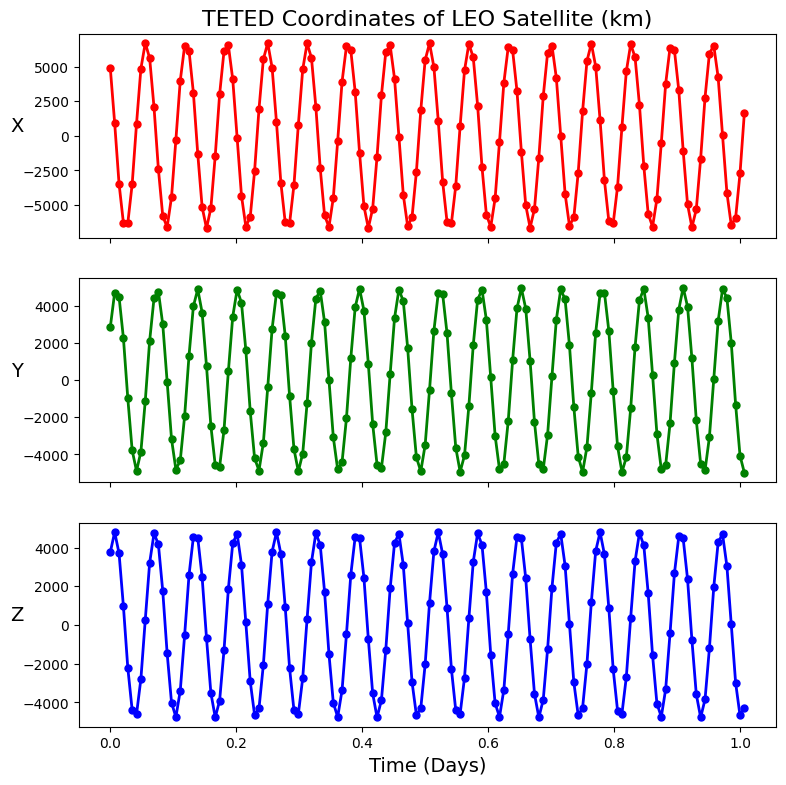

In [12]:
plot_satellite_pos(obs_times_mjd, leo_x, "LEO Satellite")

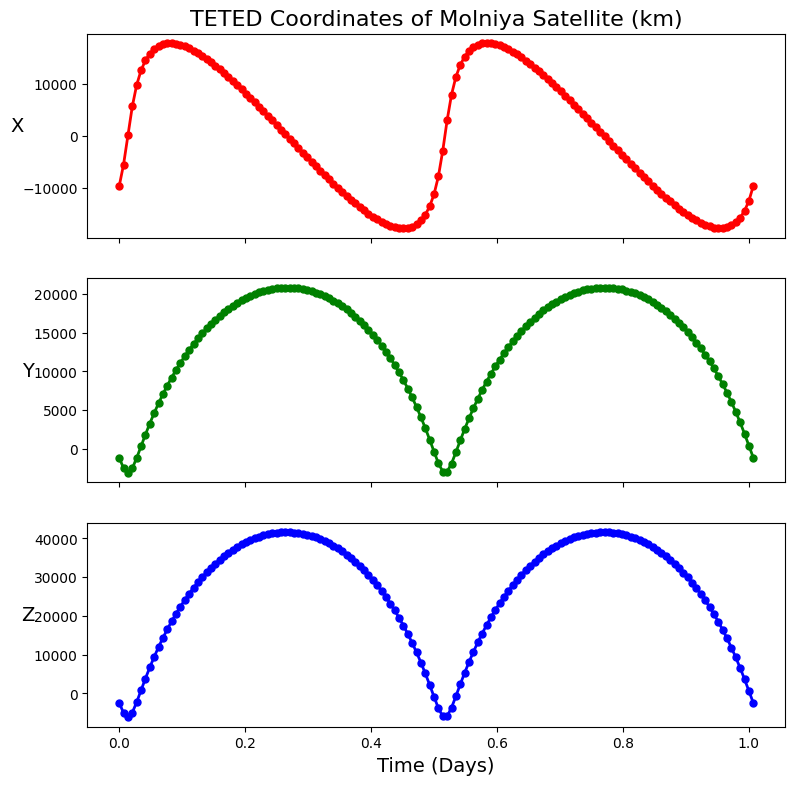

In [13]:
plot_satellite_pos(obs_times_mjd, mol_x, "Molniya Satellite")

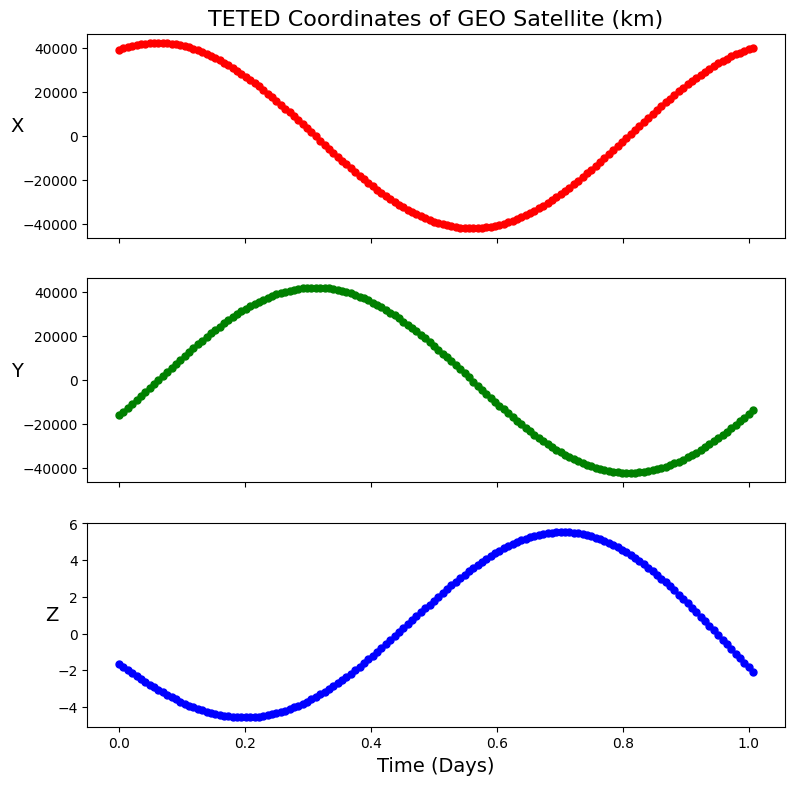

In [14]:
plot_satellite_pos(obs_times_mjd, geo_x, "GEO Satellite")

And with that, we have successfully modeled the orbital motion of three very different satellites! In practice, however, we probably can't observe a satellite 24/7, and our telescope will certainly not be perfect. Our next example will show how `madlib` can be used to simulate observations of these satellites with a realistic sensor.